---
title: Naive Bayes Classifier
author: Powell Sheagren
format:
    html:
        code-fold: true
---

In [2]:
import pandas as pd


### Introduction to Naive Bayes

Naive Bayes classifiers are a group of classification algorithms which use (naively) the independence assumption for the data and (confidently) bayes law. The method is driven by maximum likelihood estimates and can take on as many parameters as there are in the data. Despite making a naive assumption about the data, the method is still fairly competent at classifying in many situations.

By using independently distributed data I hope to use bayes' theorem's update parameters to build a gaussian model which will predict classifications. In my specific case I have tons of data related to a knitting or crocheting pattern and the goal is to see if I can determine the type of pattern (i.e. hat, socks, scarf, blanket) by using facts about the pattern such as the weight of yarn, the size of the needles, etc. I tried a few different variations of Naive bayes for this process and found categorical and gaussian approachs to be best.

To explain the rest of the document, I will start by preparing my data for use, conducting a features test to find the optimal features, running the model with those features, and then attempt a similar process with text data.


## Prepping Data

#### Record Data
As mentioned earlier, my data is labeled with the type of pattern it is and so cleaning is a simple step of separating the impactful values from the label. For future reference, I'm hoping to clear up some of the missing values as their pressence reduces the effectiveness of the model.

In [3]:
df = pd.read_csv("../data/pattern_data_updated.csv")

C:\Users\duckd\AppData\Local\Temp\ipykernel_29272\2793938783.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/pattern_data_updated.csv")


In [24]:
df.isnull().sum()

Unnamed: 0                       0
comments_count                   0
currency                     17866
price                            0
currency_symbol              17878
free                             1
published                     4378
difficulty_average               0
favorites_count                  0
projects_count                   0
queued_projects_count            0
gauge                        15897
gauge_divisor                 2793
gauge_pattern                28548
row_gauge                    25825
id                               0
name                             0
permalink                        0
rating_average                   0
rating_count                     0
yardage                      11931
yardage_max                  11931
yarn_weight_description          0
yarn_weight                  96309
needle_sizes_us              12844
needle_sizes_metric              0
hook_size                    24860
needle_sizes_name                0
craft               

In [4]:
x = df[["price",
        "free",
        "difficulty_average",
        "gauge","gauge_divisor","row_gauge",
        "rating_average","rating_count",
        "yardage","yardage_max",
        "yarn_weight_description",
        "needle_sizes_metric",
        "pattern_type"]].dropna()
y = x["pattern_type"]
x.drop("pattern_type",inplace = True,axis = 1)
x["free"] = x["free"].astype("category")

After clarifying my feature data (x) and my target data (y), I now have representative data for the naive bayes model I hope to use. I have also imported the sklearn test train split in the code below. I decided a 80-20 split was appropriate as its industry standard and allows for some wiggle room if more testing is needed.

### Feature Selection

So I will start by writing a function for running a NB test and then applying my own data to the process. I gave it a few test runs with different types of models after importing the correct packages and executing the function. 

The function itself takes in the label and feature data, splits it into train and test sets, fits the training data to the model, tests it on the remaining data, and then compares the results with the correct options; this leaves an accuracy score calculable.

In [5]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time
import numpy as np


def train_NB_model(X,Y,i_print=False, model_type = "multinomial"):

    if(i_print):
        print(X.shape,Y.shape)

    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = .2,random_state = 1)

    # INITIALIZE MODEL 
    if model_type == "categorical":
        model = CategoricalNB()
    elif model_type == "multinomial":
        model = MultinomialNB()
    elif model_type == "bernoulli":
        model = BernoulliNB()
    elif model_type == "complement":
        model = ComplementNB()
    elif model_type == "gaussian":
        model = GaussianNB()

    # TRAIN MODEL 
    model.fit(x_train,y_train)

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100

    if(i_print):
        print(acc_train,acc_test)

    return (acc_train,acc_test)

test_types = ["categorical","multinomial","bernoulli","complement","gaussian"]

#TEST
for i in range(0,len(test_types)):
    print(test_types[i])
    (acc_train,acc_test)=train_NB_model(x[["yardage","yardage_max","needle_sizes_metric","gauge"]],y,i_print = True,model_type = test_types[i])

categorical
(66154, 4) (66154,)
49.16954821155263 45.506764416899706
multinomial
(66154, 4) (66154,)
33.54307201027908 33.85231652936286
bernoulli
(66154, 4) (66154,)
16.714849876235284 16.748545083515985
complement
(66154, 4) (66154,)
36.62679742267067 36.37669110422493
gaussian
(66154, 4) (66154,)
43.174045311112366 43.3905222583327


The results are printed out with the train accuracy first and the test accuracy second. Above it the shape of the dataframe is listed although it is the same for all the data.

As the quick test shows, the categorical model seems to predict the best out of all of them but the gaussian is more consistent. Some of the features are categorical like but more are numeric so I'm thinking of using both and comparing the success rates. I will move on to doinng a feature test with the two models to see what the highest accuracy rate I can get is. Otherwise we now have a functional equation and a subtype of the naive bayes classifier so I'm ready to try out some of the subsets to see what works best. I'll be using the gaussian model first and categorical second.

In [35]:
import itertools

subsets = []
list1 = [*range(1,x.shape[1])]; #print(list1)

train_accs_g = []
test_accs_g = []
num_features_g = []
best_test_acc_g = 0

# x.shape[1]+1
for l in range(1,x.shape[1]+1):
    for subset in itertools.combinations(x.columns, l):
        train_acc, test_acc = train_NB_model(x.loc[:,list(subset)],y,model_type="gaussian")
        train_accs_g.append(train_acc)
        test_accs_g.append(test_acc)
        num_features_g.append(len(list(subset)))
        if test_acc > best_test_acc_g:
            best_test_acc_g = test_acc
            best_subset_g = list(subset)

print(best_subset_g)



['gauge', 'rating_average', 'yardage_max', 'yarn_weight_description', 'needle_sizes_metric']


In [43]:
train_acc, test_acc = train_NB_model(x.loc[:,best_subset_g],y,i_print=False,model_type = "gaussian")
print(str(train_acc) + " "+ str(test_acc))

47.83742418230259 45.17421207769632


In [44]:
import itertools

subsets = []
list1 = [*range(1,x.shape[1])]; #print(list1)

train_accs_c = []
test_accs_c = []
num_features_c = []
best_test_acc_c = 0

# x.shape[1]+1
for l in range(1,x.shape[1]+1):
    for subset in itertools.combinations(x.columns, l):
        train_acc, test_acc = train_NB_model(x.loc[:,list(subset)],y,model_type="categorical")
        train_accs_c.append(train_acc)
        test_accs_c.append(test_acc)
        num_features_c.append(len(list(subset)))
        if test_acc > best_test_acc_c:
            best_test_acc_c = test_acc
            best_subset_c = list(subset)

print(best_subset_c)


['price', 'difficulty_average', 'gauge', 'gauge_divisor', 'row_gauge', 'yardage', 'yardage_max', 'yarn_weight_description', 'needle_sizes_metric']


In [45]:
train_acc, test_acc = train_NB_model(x.loc[:,best_subset_c],y,i_print=False,model_type = "categorical")
print(str(train_acc) + " "+ str(test_acc))

49.9707121667328 47.00324994331494


We were left with two different best sets with the categorical set being much larger with more features and a slightly better accuracy. These are interesting results and what honestly was to be expected. The different variables are treated differently in the models so it is mainly more interesting to see that more variables make sense categorically than numerically.

Anyhow, below is a mapping of the amount of features by accuracy. There are discrete amounts of features possible but some were more impactful than the others which lead to within subset length hierarchies.


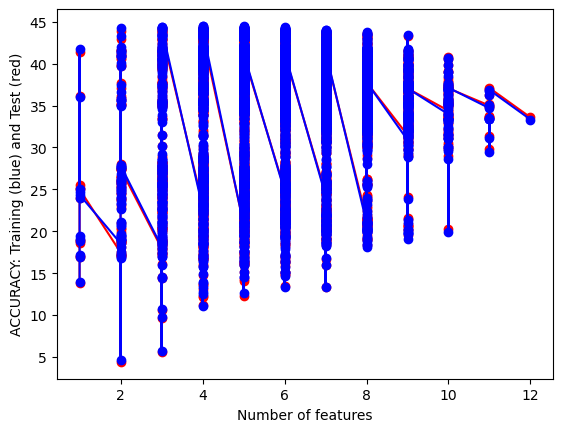

In [40]:
import matplotlib.pyplot as plt 

## Gaussian distribution
plt.plot(num_features_g,train_accs_g,'-or')
plt.plot(num_features_g,test_accs_g,'-ob')
plt.xlabel('Number of features')
plt.ylabel('ACCURACY: Training (blue) and Test (red)')
plt.show()


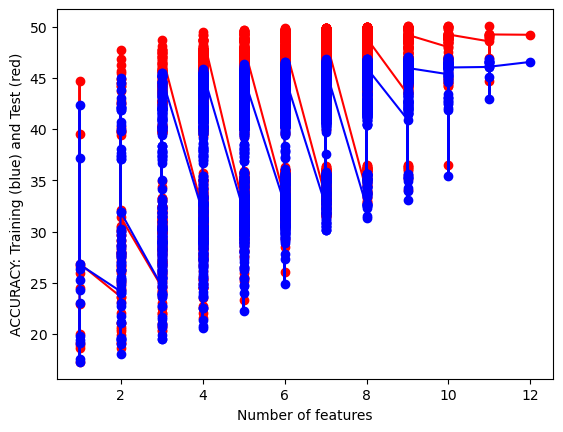

In [46]:
plt.plot(num_features_c,train_accs_c,'-or')
plt.plot(num_features_c,test_accs_c,'-ob')
plt.xlabel('Number of features')
plt.ylabel('ACCURACY: Training (blue) and Test (red)')
plt.show()

It can be seen that for the gaussian naive bayes the test set does as well as if not better than the training set while that relationship is the opposite with the categorical naive bayes. This is an interesting result considering the data and shows that, while categorical methods may give better accuracy, the gaussian model works as a better fir for predicting thed ata..

### Results

Between the two models we have accuracy scores of around 44% and 47% for test data sets which is much lower than we would want in a commercial setting. However, this accuracy score is just one way to understand the success of the model but with some many target classes it is the easiest to understand. A confusion matrix would be harder to interpret and thus I decided to simplify the results for ease of comparability. I will be doing the same for other classifying model.

I don't believe my model is over or under fitted at the moment as the training accuracy is remarkably close to the test accuracy. This low accuracy is not wildly surprising due to the sparsity of the data and the complexity of the labels. from the data there are dozens of labels that crisscross and overlap across many different values. Knitting and crocheting patterns for different objects may overlap in similar needle sizes or amount of yarn so all things considered a 44 percent accuracy is still solid. I'm curious to compare this to the other classification models and I think its interesting how it does compare to other methods in efficiency.


### Naive Bayes with Labeled Text Data

I have made a starting attempt with the text data I have available but I run into the issue of ironically having too much data. The function requires a numpy array but the array would be 170 GB with the data that I have available. I tried to assuage this as was succesful by having a minimum amount of times a word would show up and getting ride of words that did not show up as much. The data went from having 260,000 features to 10643 which is fairly drastic but makes the analysis possible in the first place. This may end up limiting the analysis of key words but I am curious to see what the results will be with it as it is.

In [6]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

intermediary = df[["pattern_type","pattern_desc"]].dropna()
pattern_text_data = intermediary["pattern_desc"]

## Testing one of the descriptions
# print(pattern_text_data[0])

## vectorizing the values
vectorizer = CountVectorizer(min_df=.0007)
vectorized_data = vectorizer.fit_transform(pattern_text_data)
print(str(vectorized_data.shape[0]) + " by "+ str(vectorized_data.shape[1]))
vectorized_data = np.array(vectorized_data.todense())

##one hot vecotr?
maxs = np.max(vectorized_data,axis = 0)
X = np.ceil(vectorized_data/maxs)
y = intermediary[["pattern_type"]]

print(X.shape,y.shape)

94189 by 10643
(94189, 10643) (94189, 1)


In [7]:

print("Multinomial")
train_acc, test_acc = train_NB_model(X,y,model_type = "multinomial")
print(train_acc,test_acc)


Multinomial


c:\Users\duckd\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


63.515235162968466


This testing accuracy is probably the best result we've gotten in terms of predictive ability but it is surprisingly low considering for most descriptions people say what the pattern is and give a ton of information about it. Some of this may be due to the limitations I made in order to progress with the data. Having more network power will overcome this hopefully. I'm looking forward to the chance to use this modeling approach to better predict information.